In [1]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
NUM_ARMS = 10
STEPS = 20
NUM_RUNS = 1

In [3]:
class Arm:
    def __init__(self):
        self.mean = 0
        self.variance = 1
    def get_reward(self):
        return np.random.normal(self.mean, self.variance, 1)[0]
    def change_mean(self):
        change = np.random.normal(0, 0.01, 1)
        self.mean += change
class Player:
    def __init__(self, param, name):
        self.param = param
        self.step = 0
        self.name = name
        self.sum_rewards = 0 # Sum of rewards in the last half.
    def get_avg_reward(self):
        return self.sum_rewards / (STEPS / 2)

In [4]:
class GreedyPlayer(Player):
    def __init__(self, init_value):
        self.estimations = [init_value for _ in range(NUM_ARMS)]
        self.alpha = 0.1
        Player.__init__(self, init_value, "optimistic greedy")
    def choose(self):
        m = max(self.estimations)
        self.chosen = self.estimations.index(m)
        return self.chosen
    def update_inner_state(self, reward):
        self.step += 1
        if self.step > STEPS / 2:
            self.sum_rewards += reward
        self.estimations[self.chosen] += self.alpha \
            * (reward - self.estimations[self.chosen])

In [5]:
class EpsilonGreedyPlayer(Player):
    def __init__(self, epsilon):
        self.estimations = [0 for _ in range(NUM_ARMS)]
        self.alpha = 0.1
        self.epsilon = epsilon
        Player.__init__(self, epsilon, "epsilon-greedy")        
    def choose(self):
        m = max(self.estimations)
        rnd = np.random.uniform()
        if rnd < self.epsilon:
            self.chosen = np.random.choice(range(NUM_ARMS))
        else:
            self.chosen = self.estimations.index(m)
        return self.chosen
    def update_inner_state(self, reward):
        self.step += 1
        if self.step > STEPS / 2:
            self.sum_rewards += reward
        self.estimations[self.chosen] += self.alpha \

In [6]:
class UCBPlayer(Player):
    def __init__(self, c):
        self.estimations = [0 for _ in range(NUM_ARMS)]
        self.arm_selected = [0 for _ in range(NUM_ARMS)] # Number of times
#         an arm was selected.
        self.c = c
        Player.__init__(self, c, "UCB")    
    def choose(self):
        ucb = []
        for a in range(NUM_ARMS):
            if self.arm_selected[a] == 0:
                ucb.append(1000)
            else:
                uncertainty = math.sqrt(math.log(self.step + 1)/self.arm_selected[a])
                ucb.append(self.estimations[a] + self.c * uncertainty)
        m = max(ucb)
        self.chosen = ucb.index(m)
        return self.chosen
    def update_inner_state(self, reward):
        self.step += 1
        if self.step > STEPS / 2:
            self.sum_rewards += reward
        self.arm_selected[self.chosen] += 1
        self.estimations[self.chosen] += (1.0 / self.step) \
        * (reward - self.estimations[self.chosen])

In [10]:
class GradientBanditPlayer(Player):
    def __init__(self, alpha):
        self.preferences = [0 for _ in range(NUM_ARMS)]
        self.full_sum_rewards = 0
        self.alpha = alpha
        Player.__init__(self, alpha, "gradient bandit")
    def choose(self):
        exps = [math.exp(pref) for pref in self.preferences]
        sum_exps = sum(exps)
        self.probs = [exp / sum_exps for exp in exps]
        self.chosen = np.random.choice(10, p=self.probs)
        return self.chosen
    def update_inner_state(self, reward):
        if self.step == 0:
            avg_before = 0
        else:
            avg_before = self.full_sum_rewards / self.step
        self.step += 1
        if self.step > STEPS / 2:
            self.sum_rewards += reward
        self.full_sum_rewards += reward
        for a in range(NUM_ARMS):
            if a == self.chosen:
                self.preferences[a] += (self.alpha *
                                        (reward - avg_before) *
                                        (1 - self.probs[a]))
            else:
                self.preferences[a] -= (self.alpha *
                                        (reward - avg_before) *
                                        self.probs[a])

In [11]:
players = (
    [GreedyPlayer(q) for q in [2 ** i for i in range(-2, 3)]] +
    [EpsilonGreedyPlayer(e) for e in [2 ** i for i in range(-7, -1)]] +
    [UCBPlayer(c) for c in [2 ** i for i in range(-4, 3)]] +
    [GradientBanditPlayer(a) for a in [2 ** i for i in range(-4, 3)]]
)
avg_rewards = defaultdict(lambda: defaultdict(list))

In [12]:
%%time
for player in players:
    sum_avg_reward = 0
    for _ in range(NUM_RUNS):
        arms = [Arm() for _ in range(NUM_ARMS)]
        for _ in range(STEPS):
            a = arms[player.choose()]
            r = a.get_reward()
            player.update_inner_state(r)
            a.change_mean()
        sum_avg_reward += player.get_avg_reward()
    avg_rewards[player.name]["x"].append(player.param)
    avg_rewards[player.name]["y"].append(sum_avg_reward/NUM_RUNS)
    print(avg_rewards)

CPU times: user 17.6 ms, sys: 1.06 ms, total: 18.7 ms
Wall time: 17.7 ms


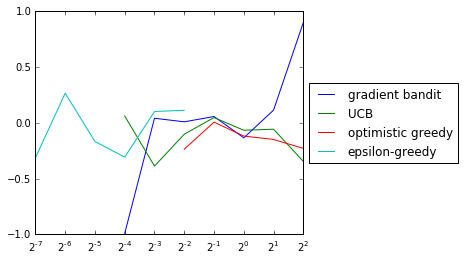

In [13]:
fig, ax = plt.subplots()
for name, results in avg_rewards.items():
    ax.plot(results["x"], results["y"], label=name)
ax.set_xscale("log", basex=2)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("2.11.png")